<a href="https://colab.research.google.com/github/JorgeTonatiuh/aprendizaje_profundo_tarea_2/blob/main/prediccion_edades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de edades

Entrenar modelos de regresión para predecir edades en el conjunto de
datos UTKFace.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os
# marcas de tiempo
import datetime
# marcas de tiempo
import time
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# sistema de archivos
from os.path import join
# sistema de archivos
from os.path import join
import math
import seaborn as sns

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as tvm
import torchvision.datasets.utils as tvutils
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter

# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import trange
# imágenes
from PIL import Image
from sklearn.model_selection import train_test_split

### 1.2. Auxiliares

In [3]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 224
# Corte al centro
IMG_CORP = 210
# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            ax[r, c].axis('off')
            i += 1
    fig.tight_layout()
    
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

def display_batch_net(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x

def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)

# reproducibilidad
set_seed()

## 2 Datos

Implementar la tubería de datos usando el conjunto de rostros alineados y recortados.

### 2.2 Descarga de UTKFace

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../data/faces/UTKFace.tar.gz’ already there; not retrieving.


### 2.3 Conjunto de datos

Las etiquetas de cada imagen están definidas en el nombre del archivo, formateadas como: edad_genero_raza_fecha&tiempo.jpg

- Edad: es un entero entre 0 y 116, indica la edad.

- Genero: es 0 para hombre y 1 para mujer.

- Raza: es un entero de 0 a 4, denotando Blanco, Negro, Asiatico, Indu y Otro (como Hispano, Latino, Medio este).

- Fecha&Tiempo: esta en formato yyyymmddHHMMSSFFF, mostrando la fecha y tiempo en que la imagen fué recolectada a UTKFace.

In [5]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


Se construye un DataFrame con las rutas de los nombres de las imagenes y la edad 

In [15]:
img_names = sorted(os.listdir(data_dir))
df_data = {'name': img_names, 'age': [int(img.split('_')[0]) for img in img_names]}
df_data = pd.DataFrame(df_data)
df_data

,name,age
0,100_0_0_20170112213500903.jpg.chip.jpg,100
1,100_0_0_20170112215240346.jpg.chip.jpg,100
2,100_1_0_20170110183726390.jpg.chip.jpg,100
3,100_1_0_20170112213001988.jpg.chip.jpg,100
4,100_1_0_20170112213303693.jpg.chip.jpg,100
...,...,...
23703,9_1_3_20161220222856346.jpg.chip.jpg,9
23704,9_1_3_20170104222949455.jpg.chip.jpg,9
23705,9_1_4_20170103200637399.jpg.chip.jpg,9
23706,9_1_4_20170103200814791.jpg.chip.jpg,9


Se grafican los datos para observar la distribución de las diferentes edades.

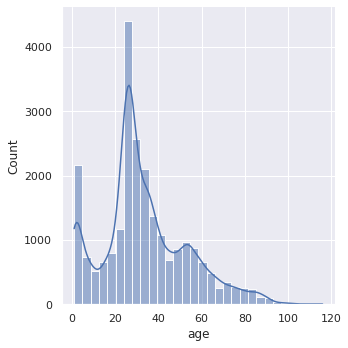

In [16]:
sns.set_theme()
sns.displot(df_data['age'],kde=True, bins=30)

In [17]:
print("Numero de ejemplos entre 24 y 28 años = ", len(df_data[(df_data['age'] >= 25) & (df_data['age'] <= 28)]))
print("Numero de ejemplos mayores a 80 años = ", len(df_data[(df_data['age'] >= 80)]))

Numero de ejemplos entre 24 y 28 años =  4464
Numero de ejemplos mayores a 80 años =  673


Lo que se observa es los siguiente:


- Existen mucha diferencia en ejemplos para las edades entre 25 y 28, se removerán algunos ejemplos entre este rango de edades para eliminar este sesgo y evitar que el modelo de preferencia a esas edades.


In [18]:
samples = [df_data.iloc[i] for i in range(len(df_data)) if df_data['age'].iloc[i] >= 25 and df_data['age'].iloc[i] <= 28]
samples = pd.DataFrame(samples)
samples = samples.sample(frac=0.4)
df_data = df_data[(df_data['age']<25) | (df_data['age']>28)]
df_data = pd.concat([df_data,samples], ignore_index = True)
df_data = df_data[df_data['age']<80]

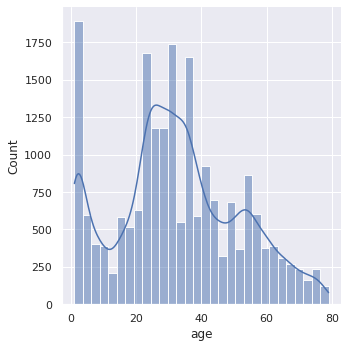

In [19]:
sns.set_theme()
sns.displot(df_data['age'],kde=True, bins=30)

Dividimos  aleatoriamente el conjunto de datos en 80% para entrenamiento y 20% para prueba. Para eso usaremos la funcion `train_test_split` de scikit-learn, y se tomarán porcentages de los rangos de edades, para evitar que el conjunto de entrenamiento se quede sin una clase determinada o rango de edad determinado.

In [20]:
x_trn, y_trn = [], []
x_val, y_val = [], [] 

by_class = df_data.groupby('age')
for group, data in by_class:
  imgs = data['name'].values.tolist()
  ages = data['age'].values.tolist()
  x_tr, x_ts, y_tr, y_ts = train_test_split(imgs, ages, test_size=0.2, random_state=42)
  x_trn.extend(x_tr)
  y_trn.extend(y_tr)
  x_val.extend(x_ts)
  y_val.extend(y_ts)

Ejemplos en Entrenamiento:  16252


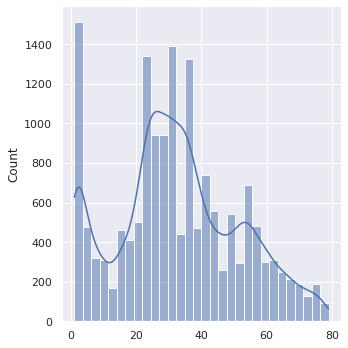

In [21]:
print("Ejemplos en Entrenamiento: ",len(x_trn))
sns.set_theme()
sns.displot(y_trn,kde=True, bins=30)

Ejemplos en Validacion:  4105


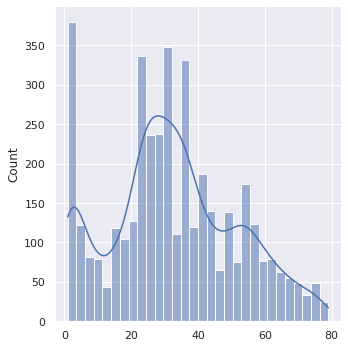

In [22]:
print("Ejemplos en Validacion: ",len(x_val))
sns.set_theme()
sns.displot(y_val,kde=True, bins=30)

Normalización de edades

In [82]:
class FacesDS:

    def __init__(self, root, tsfm, subset):
          
        # validamos argumentos
        if subset not in {'trn', 'val'}:
            ValueError(f'invalid value for subset={subset}')
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm

        # nombre de imagenes
        names = []
        target = []
        if subset == 'trn':
          names = x_trn
          target = y_trn

        if subset == 'val':
          names = x_val
          target = y_val

        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for i,name in enumerate(names):
            # directorio de la imagen
            img_dir = os.path.join(root, name)
            self.paths.append(img_dir)
            self.labels.append(target[i])
            
                

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta        
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración

x shape=torch.Size([32, 224, 224, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


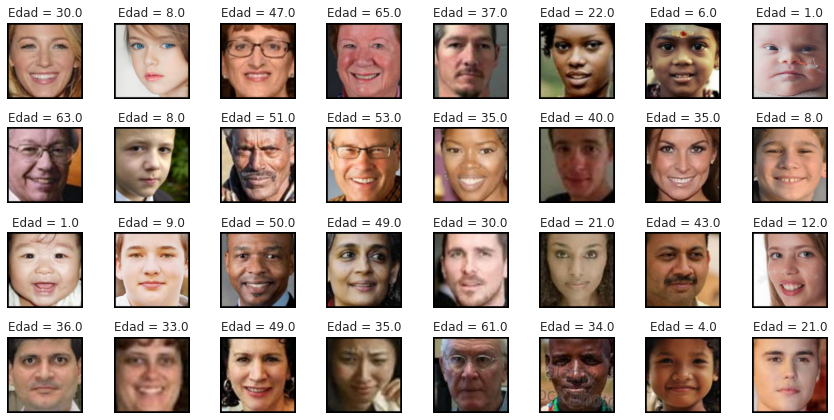

In [24]:
tsfm = transforms.Compose([
    # recortamos al centro a 224x224
    transforms.CenterCrop(IMG_CORP),
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = FacesDS(data_dir, tsfm, 'trn')

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.4 Cargador de datos

#### Entrenamiento

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


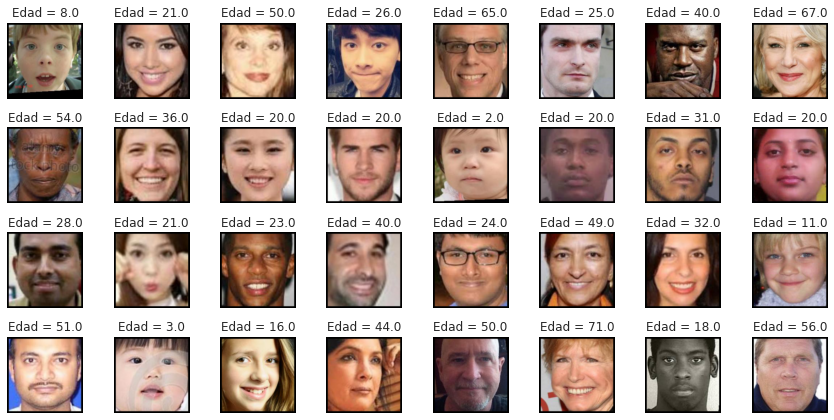

In [25]:
# transformación de entrenamiento
trn_tsfm = transforms.Compose([
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # Agregar acrecentamiento de datos usando un espejeo horizontal.
    # aumentado de datos
    # espejeo horizontal aleatorio    
    transforms.RandomHorizontalFlip(),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor()
])

# conjunto
trn_ds = FacesDS(data_dir, trn_tsfm, 'trn')

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

#### Validacion

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


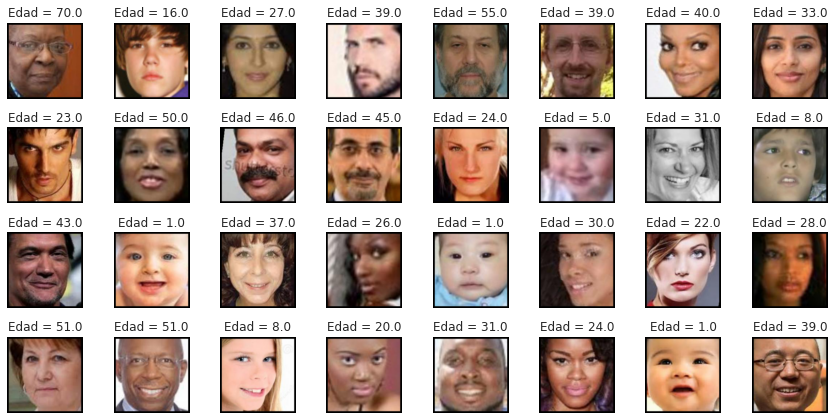

In [26]:
# transformación de entrenamiento
val_tsfm = transforms.Compose([
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor()
])

# conjunto
val_ds = FacesDS(data_dir, val_tsfm, 'val')

val_dl = DataLoader(
    # conjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(val_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3 Modelo ResNet

### 3.1 Definición de bloque ResNet

### 3.1 Definición de bloque ConNeXt

In [30]:
class ConvNextBlock(nn.Module):

    def __init__(self, in_channels, out_channels, ln):
        super(ConvNextBlock, self).__init__()
        out_channels1, out_channels2 = out_channels

        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            # [N, I, H, W] => [N, O1, H, W
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels1, 
                      kernel_size=3, padding=1),
            
            # [N, O1, H, W]
            nn.LayerNorm(round(224/ln)),

            # conv2
            # [N, O1, H, W] => [N, O2, H, W]
            nn.Conv2d(in_channels=out_channels1, 
                      out_channels=out_channels2,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
            nn.GELU(),
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x  

### 3.1 Definición de la arquitectura

In [28]:
class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 3 * 28 * 28
        
        # [N, 3, 224, 224] => [N, 3, 28, 28]
        self.cnn = nn.Sequential(
            ConvNextBlock(in_channels=3, out_channels=(3,3),l=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvNextBlock(in_channels=3, out_channels=(3,3),l=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvNextBlock(in_channels=3, out_channels=(3,3),l=4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        # [N, 3, 28, 28] => [N, 3x28x28]
        self.flatten = nn.Flatten()

        # [N, 3x28x28] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 224, 224] => [N, 3, 28, 28]
        x = self.cnn(x)
        # [N, 3, 28, 28] => [N, 3x28x28]
        x = self.flatten(x)
        # [N, 3x28x28] => [N, 1]
        x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 224, 224] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        y_prob = torch.round(y_lgts)        
        return y_prob

### 3.2 Inspección de la arquitectura

In [53]:
model = MicroResNet()
summary(model, (3, 224, 224), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 28, 28]           --
|    └─ConvNextBlock: 2-1                [-1, 3, 224, 224]         --
|    |    └─Sequential: 3-1              [-1, 3, 224, 224]         616
|    └─MaxPool2d: 2-2                    [-1, 3, 112, 112]         --
|    └─ConvNextBlock: 2-3                [-1, 3, 112, 112]         --
|    |    └─Sequential: 3-2              [-1, 3, 112, 112]         392
|    └─MaxPool2d: 2-4                    [-1, 3, 56, 56]           --
|    └─ConvNextBlock: 2-5                [-1, 3, 56, 56]           --
|    |    └─Sequential: 3-3              [-1, 3, 56, 56]           280
|    └─MaxPool2d: 2-6                    [-1, 3, 28, 28]           --
├─Flatten: 1-2                           [-1, 2352]                --
├─Linear: 1-3                            [-1, 1]                   2,353
Total params: 3,641
Trainable params: 3,641
Non-trainable params: 0
Total mult-

### 3.3 Prueba de la arquitectura

In [54]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 224, 224)
y = model(x)
y

tensor([[-0.1214]], grad_fn=<AddmmBackward0>)

## 4 Entrenamiento

### 4.1 Ciclo de entrenamiento

In [96]:
def train_epoch(dl, model, opt):
    model.train()
    # por cada lote
    for x, y_true in dl:        
        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    model.eval()
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)
            y_pred = torch.round(y_lgts)

            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true)            
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()
            
            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, val_dl, lr=1e-4, epochs=5,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):        
        # entrenamos la época
        train_epoch(trn_dl, model, opt)
        
        # evaluamos la época en entrenamiento
        val_loss, val_acc = eval_epoch(val_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(val_loss)
        acc_hist.append(val_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={val_loss:6.2f} acc={val_acc:5.2f}')

    return loss_hist, acc_hist

### 4.2 Entrenamiento

In [57]:
loss_hist, scc_hist = train(model,trn_dl,val_dl)

 20%|██        | 1/5 [04:51<19:25, 291.35s/it]

E00 loss=18170.37 acc= 3.39


 40%|████      | 2/5 [09:38<14:25, 288.65s/it]

E01 loss=17401.56 acc= 3.93


 60%|██████    | 3/5 [14:25<09:36, 288.00s/it]

E02 loss=17057.24 acc= 2.52


 80%|████████  | 4/5 [19:13<04:48, 288.05s/it]

E03 loss=13042.06 acc= 3.71


100%|██████████| 5/5 [24:01<00:00, 288.26s/it]

E04 loss=12735.60 acc= 3.95


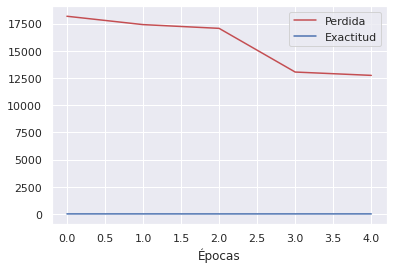

In [58]:
plt.plot(loss_hist, 'r', label='Perdida')
plt.plot(scc_hist, 'b', label='Exactitud')
plt.legend()
plt.xlabel('Épocas')
plt.show()

# Transferencia de conocimiento.

Entrenar un modelo reentrenando solo la última capa.

## 1 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

### 1.1 Carga de datos

#### Entrenamiento

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


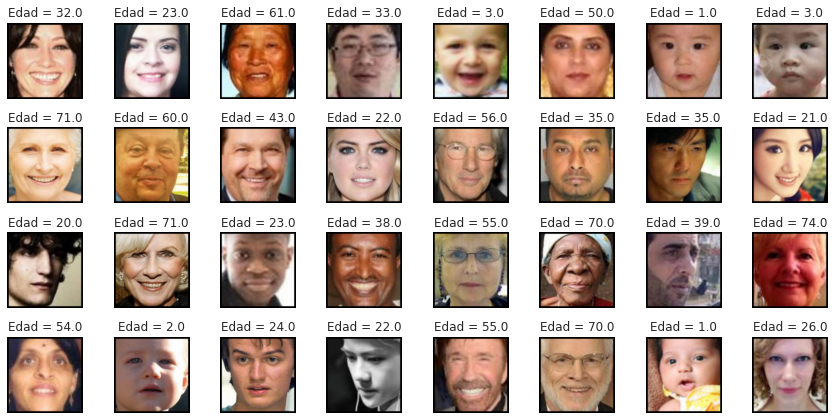

In [83]:
# transformación de entrenamiento
trn_tsfm = transforms.Compose([
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # Agregar acrecentamiento de datos usando un espejeo horizontal.
    # aumentado de datos
    # espejeo horizontal aleatorio    
    transforms.RandomHorizontalFlip(),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
    # estandarizamos con media y varianza
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto
trn_ds = FacesDS(data_dir, trn_tsfm, 'trn')

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch_net(x, titles, ROWS, COLS)

#### Validacion

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


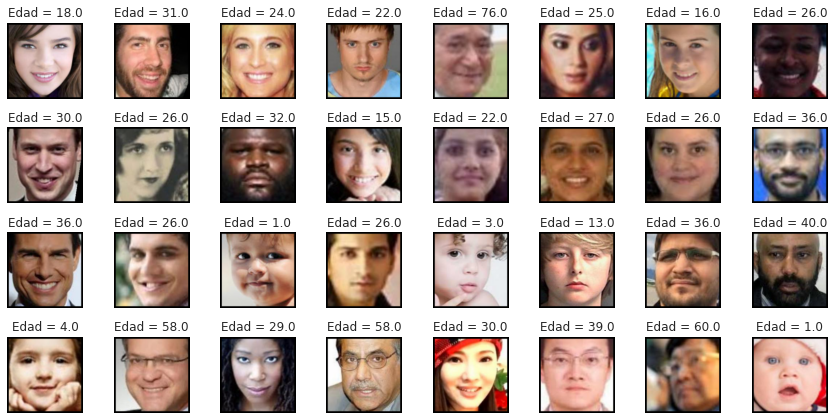

In [84]:
# transformación de entrenamiento
val_tsfm = transforms.Compose([
    # cortamos al centro 224x224
    transforms.CenterCrop(IMG_CORP),
    # redimensionamos a 224x224
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
    # estandarizamos con media y varianza
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# conjunto
val_ds = FacesDS(data_dir, val_tsfm, 'val')

val_dl = DataLoader(
    # conjunto
    val_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(val_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch_net(x, titles, ROWS, COLS)

### 1.1 Carga de pesos

In [87]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 1.2 Transferencia de conocimiento

In [88]:
# congelamos los parámetros
for param in model.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = nn.Linear(1024, 1)

# inspección
summary(model, (3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 24, 112, 112]        (648)
|    └─BatchNorm2d: 2-2                  [-1, 24, 112, 112]        (48)
|    └─ReLU: 2-3                         [-1, 24, 112, 112]        --
├─MaxPool2d: 1-2                         [-1, 24, 56, 56]          --
├─Sequential: 1-3                        [-1, 48, 28, 28]          --
|    └─InvertedResidual: 2-4             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-1              [-1, 24, 28, 28]          (888)
|    |    └─Sequential: 3-2              [-1, 24, 28, 28]          (1,512)
|    └─InvertedResidual: 2-5             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-3              [-1, 24, 28, 28]          (1,512)
|    └─InvertedResidual: 2-6             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-4              [-1, 24, 28, 28]          

## 2 Entrenamiento

### 2.1 Funciones de entrenamiento

In [103]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for x, y_true in dl:
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes        
        for x, y_true in take(dl, num_batches):
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # obtenemos la predic
            y_pred = torch.round(y_lgts)          
            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true)
            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100
        
        return loss, acc

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-4)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    trn_loss_hist, trn_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []
    # ciclo de entrenamiento
    best_acc = 0
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # guardamos historial
        trn_loss_hist.append(trn_loss)
        trn_acc_hist.append(trn_acc)

        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)
        # guardamos historial
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        val_writer.add_scalar('metrics/acc', val_acc, epoch)
        # imprimimos progreso
        print(f'E{epoch:02} loss={val_loss:6.2f} acc={val_acc:5.2f}')
        
        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_acc > best_acc:
            best_acc = val_acc
            save_check_point(model, epoch, run_dir)
    return  trn_loss_hist, trn_acc_hist, val_loss_hist, val_acc_hist           

### 2.2 Monitoreo

In [90]:
# directorio de la corrida
run_dir = join('runs', 'utkface', timestamp())
run_dir

'runs/utkface/221107T060345'

In [91]:
# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))

In [92]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

runs/utkface/221107T060345:
trn/  val/

runs/utkface/221107T060345/trn:
events.out.tfevents.1667801026.0cff273263a1.3535.4

runs/utkface/221107T060345/val:
events.out.tfevents.1667801026.0cff273263a1.3535.5


In [93]:
# entrenamos modelo
trn_loss_hist, trn_acc_hist, val_loss_hist, val_acc_hist = train(model, trn_dl, val_dl, trn_writer, val_writer, epochs=5, trn_batches=5, val_batches=5)

 20%|██        | 1/5 [03:18<13:14, 198.74s/it]

E00 loss=130399.41 acc= 5.62


 40%|████      | 2/5 [06:37<09:55, 198.48s/it]

E01 loss=112676.30 acc= 6.88


 60%|██████    | 3/5 [09:55<06:36, 198.41s/it]

E02 loss=123844.06 acc= 3.12


 80%|████████  | 4/5 [13:13<03:18, 198.34s/it]

E03 loss=102120.51 acc= 1.88


100%|██████████| 5/5 [16:29<00:00, 197.87s/it]

E04 loss=115760.84 acc= 0.00


Graficas de historial de perdida y exactitud.

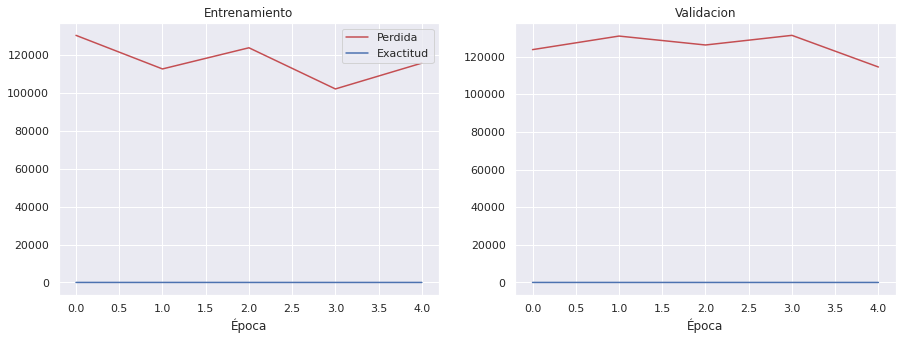

In [95]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(trn_loss_hist, 'r', label='Perdida')
axs[0].plot(trn_acc_hist, 'b', label='Exactitud')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(val_loss_hist, 'r', label='Perdida')
axs[1].plot(val_acc_hist, 'b', label='Exactitud')
axs[1].title.set_text("Validacion")
axs[1].set_xlabel(u'Época')

plt.show()

In [97]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

runs/utkface/221107T060345:
trn/  val/  weights.pth

runs/utkface/221107T060345/trn:
events.out.tfevents.1667801026.0cff273263a1.3535.4

runs/utkface/221107T060345/val:
events.out.tfevents.1667801026.0cff273263a1.3535.5


## 3. Evaluación

### 3.1 Cargando modelo

In [100]:
# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 0


In [101]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 1)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

### 3.3 Evaluación Final 

In [104]:
device = torch.device('cpu')
trn_loss, trn_acc = eval_epoch(trn_dl, model, device)
val_loss, val_acc = eval_epoch(val_dl, model, device)

In [105]:
print(f'trn_acc={trn_acc:5.2f} val_acc={val_acc:5.2f}')

trn_acc= 5.52 val_acc= 5.45


In [106]:
print(f'trn_loss={trn_loss:6.2f} val_loss={val_loss:6.2f}')

trn_loss=136385.61 val_loss=137367.88


# Transferencia de conocimiento.

Entrenar un modelo reentrenando toda la red.

## 1 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [RESNET18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18), una arquitectura eficiente para clasificación de imágenes. 

### 1.1 Carga de pesos

In [110]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 1.2 Transferencia de conocimiento

In [111]:
# remplazo de última capa
model.fc = nn.Linear(1024, 1)

# inspección
summary(model, (3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 24, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 24, 112, 112]        648
|    └─BatchNorm2d: 2-2                  [-1, 24, 112, 112]        48
|    └─ReLU: 2-3                         [-1, 24, 112, 112]        --
├─MaxPool2d: 1-2                         [-1, 24, 56, 56]          --
├─Sequential: 1-3                        [-1, 48, 28, 28]          --
|    └─InvertedResidual: 2-4             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-1              [-1, 24, 28, 28]          888
|    |    └─Sequential: 3-2              [-1, 24, 28, 28]          1,512
|    └─InvertedResidual: 2-5             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-3              [-1, 24, 28, 28]          1,512
|    └─InvertedResidual: 2-6             [-1, 48, 28, 28]          --
|    |    └─Sequential: 3-4              [-1, 24, 28, 28]          1,512
|   

### 2.2 Monitoreo con Tensorboard

In [112]:
# directorio de la corrida
run_dir = join('runs', 'utkface', timestamp())
run_dir

'runs/utkface/221107T065321'

In [113]:
# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))

In [114]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

runs/utkface/221107T065321:
trn/  val/

runs/utkface/221107T065321/trn:
events.out.tfevents.1667804003.0cff273263a1.3535.6

runs/utkface/221107T065321/val:
events.out.tfevents.1667804003.0cff273263a1.3535.7


In [115]:
# entrenamos modelo
trn_loss_hist, trn_acc_hist, val_loss_hist, val_acc_hist = train(model, trn_dl, val_dl, trn_writer, val_writer, epochs=5, trn_batches=5, val_batches=5)

 20%|██        | 1/5 [07:32<30:10, 452.52s/it]

E00 loss=13950.39 acc= 4.38


 40%|████      | 2/5 [15:09<22:45, 455.27s/it]

E01 loss=11232.01 acc= 4.38


 60%|██████    | 3/5 [22:36<15:03, 451.51s/it]

E02 loss=13102.37 acc= 2.50


 80%|████████  | 4/5 [30:01<07:28, 448.75s/it]

E03 loss=8795.68 acc= 8.12


100%|██████████| 5/5 [37:22<00:00, 448.53s/it]

E04 loss=9629.42 acc= 8.12


Graficas de historial de perdida y exactitud.

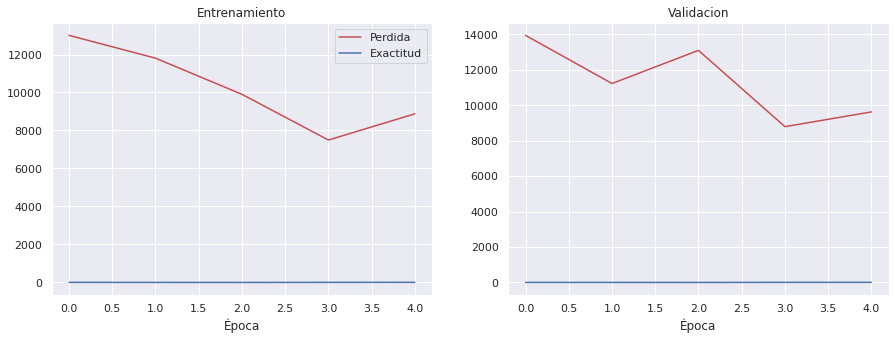

In [116]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(trn_loss_hist, 'r', label='Perdida')
axs[0].plot(trn_acc_hist, 'b', label='Exactitud')
axs[0].title.set_text('Entrenamiento')
axs[0].set_xlabel(u'Época')
axs[0].legend()

axs[1].plot(val_loss_hist, 'r', label='Perdida')
axs[1].plot(val_acc_hist, 'b', label='Exactitud')
axs[1].title.set_text("Validacion")
axs[1].set_xlabel(u'Época')

plt.show()

In [117]:
# inspeccionemos el directorio de la corrida
%ls -R {run_dir}

runs/utkface/221107T065321:
trn/  val/  weights.pth

runs/utkface/221107T065321/trn:
events.out.tfevents.1667804003.0cff273263a1.3535.6

runs/utkface/221107T065321/val:
events.out.tfevents.1667804003.0cff273263a1.3535.7


## 3. Evaluación

### 3.1 Cargando modelo

In [118]:
# cargamos el punto de contral
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 3


In [119]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 1)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

### 3.3 Evaluación Final 

In [120]:
device = torch.device('cpu')
trn_loss, trn_acc = eval_epoch(trn_dl, model, device)
val_loss, val_acc = eval_epoch(val_dl, model, device)

In [121]:
print(f'trn_acc={trn_acc:5.2f} val_acc={val_acc:5.2f}')

trn_acc= 5.18 val_acc= 5.52


In [122]:
print(f'trn_loss={trn_loss:6.2f} val_loss={val_loss:6.2f}')

trn_loss=8806.42 val_loss=8952.78
